# SRGAN Output - FRC Test

**PART 1**

**Goal**: Our goal here is to figure out the weaknesses of the SRGAN outputs in the FRC curve.

**What we do in this PART 1**: 

    1) Read the benchmark_test.py outputs which include SRGAN predictions as well as bicubic and bilinear interpolations.
    2) Generate 96x96 patches from the images (we'll run FRC on the 96x96 patches because this is what happens in the training process).
    3) Run FRC on each of the 3 classes (restored, bicubic, bilinear) against the ground truth patches.
    4) Take the mean of all the FRC curves for each class and plot.
    
**RESULT**:

We have found that the SRGAN output does better than bilinear and bicubic in the low frequencies (radius < 30), however does worse for the high frequencies (radius > 30). An interesting idea was that, what happens if we just replace the high frequencies of bilinear/bicubic with the SRGAN to improve it? Anyways, a natural question is, how influential are these high frequencies to the overall image quality. PART 2 investigates that.
    
**PART 2**

**Goal**: Having seen the weaknesses of the SRGAN FRC output, here we investigate how important these frequency bands for the image patches. 

**Discussion**: If these frequency bands had very tiny effect on the overall image quality, it would be waste of time to try to improve them. So, here we desing an experiment to figure out the contribution of these frequencies to the 1) energy 2) ssim of the images. Here is what we do:


**What we do in this PART 2**: 

    1) Extract ground truth patches from the test images.
    2) Take the Fourier transform of them and fftshift.
    3) Generate a set of ideal low pass filters: circles (not rings!) with radii corresponding to each frequency bin in the FRC curve.
    4) Take the inner product of the fftshifted Fourier domain patches with each of the circles.
    5) Take the energy of each of the filtered images and normalize them with the original versions. Then take the average of these normalized energy ratios in the image axis. Plot the average normalized energy ratios as a function of increased circle radius.
    6) Now instead of energy, do the same for the SSIM. Compute the SSIM of the filtered images against the original ones. Take the average of the ssims in the image axis. Plot the average ssims as a function of increased circle radius.
  
  
**RESULT**:

We have found that the high frequencies in the 96x96 patches have considerable impact on the image quality (SSIM). For example, if we filter out frequencies with radius>30, our SSIM drops to 0.85. This means that it is worth pursuing our goal and try to improve the SRGAN training using FRC based metrics.

In [1]:
%pylab inline
from metrics import get_frc
from skimage.color import rgb2gray
import glob
get_frcs = np.vectorize(get_frc, excluded=['corners'], signature='(i,j),(i,j)->(k)')

Populating the interactive namespace from numpy and matplotlib


# PART 1

### Parse and read the SRGAN Outputs as well as Bicubic & Bilinear Interpolated Images

In [2]:
# testpath = './data/initial_results*/'
testpath = './data/larger_initial*/'
hr_files = glob.glob(testpath+'*hr_psnr*')
hr_restore_files = glob.glob(testpath+'*sr_psnr*') # parse the filenames
hr_bicubic_files = glob.glob(testpath+'*hr_restore_BICU*')
hr_bilinear_files = glob.glob(testpath+'*hr_restore_BILI*')
hr_files.sort() # sort all the files to make sure they're in the same order
hr_restore_files.sort()
hr_bicubic_files.sort()
hr_bilinear_files.sort()
hr = []
hr_restore = []
hr_bicubic = []
hr_bilinear = []
for i in range(len(hr_files)):
    hr.append(rgb2gray(np.moveaxis(np.load(hr_files[i])[0],0,-1)))
    hr_restore.append(rgb2gray(np.moveaxis(np.load(hr_restore_files[i])[0],0,-1)))
    hr_bicubic.append(rgb2gray(np.moveaxis(np.load(hr_bicubic_files[i])[0],0,-1)/255.))
    hr_bilinear.append(rgb2gray(np.moveaxis(np.load(hr_bilinear_files[i])[0],0,-1)/255.))

### Extract patches from the images and put them in arrays for each class

In [3]:
stride = 20
psize = 96
phr = []
phr_restore = []
phr_bicubic = []
phr_bilinear = []
for i in range(len(hr)):
    r, c = hr[i].shape
    rows = np.arange(0,r-psize,stride)
    cols = np.arange(0,c-psize,stride)
    for row in rows:
        for col in cols:
            phr.append(hr[i][row:row+psize, col:col+psize])
            phr_restore.append(hr_restore[i][row:row+psize, col:col+psize])
            phr_bicubic.append(hr_bicubic[i][row:row+psize, col:col+psize])
            phr_bilinear.append(hr_bilinear[i][row:row+psize, col:col+psize])
phr = np.array(phr)
phr_restore = np.array(phr_restore)
phr_bicubic = np.array(phr_bicubic)
phr_bilinear = np.array(phr_bilinear)

### Take the FRCs of each class of patches against the ground truth partches

In [5]:
frc_restore = get_frcs(phr, phr_restore)
frc_bicubic = get_frcs(phr, phr_bicubic)
frc_bilinear = get_frcs(phr, phr_bilinear)

### Plot the average FRC curves for each class

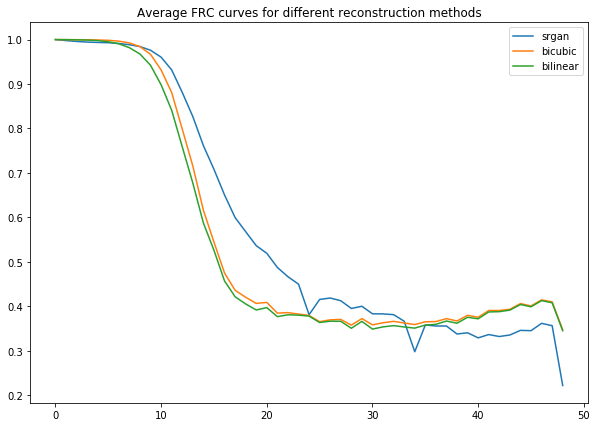

In [10]:
# ind = np.random.permutation(frc_restore.shape[0])[:100]
ind = np.arange(frc_restore.shape[0])
plt.figure(figsize=(10,7))
plt.title('Average FRC curves for different reconstruction methods')
plt.plot(np.mean(frc_restore[ind], axis=0).real, label='srgan')
plt.plot(np.mean(frc_bicubic[ind], axis=0).real, label='bicubic')
plt.plot(np.mean(frc_bilinear[ind], axis=0).real, label='bilinear')
plt.legend()
plt.savefig('./frc_comparison.png')

# PART 2

### Take some original image patches and take their fftshifted Fourier transforms

In [ ]:
hrset = phr[np.random.permutation(phr.shape[0])[:100]]
hrset_f = np.fft.fftshift(np.fft.fft2(hrset), axes=(1,2))

### Generate the circles with all the radii corresponding to the FRC frequencies

In [ ]:
r = np.arange(hrset.shape[-1]) - hrset.shape[-1]//2
[xx, yy] = np.meshgrid(r,r)
radii = np.sqrt(xx**2+yy**2)
maxrad = hrset.shape[-1]//2
circles = np.array([(radii<radius+0.5).astype(int) for radius in range(maxrad+1)])

### Multiply the Fourier domain images with the circles to filter them

In [ ]:
circmuls = np.einsum('ikl,jkl->ijkl', circles,hrset_f)

### Take the inverse FT of the filtered Fourier domain images

In [ ]:
circmuls_if = np.fft.ifft2(np.fft.fftshift(circmuls, axes=(2,3))).real

### Compute the normalized energies of each set of filtered images

In [ ]:
energies_circ = np.sum(abs(circmuls)**2, axis=(2,3))
energies_ref = np.sum(abs(hrset_f)**2, axis=(1,2))[np.newaxis,:]
energies_rel = energies_circ / energies_ref

### Plot the normalized energy ratios as a function of increasing filter radius

In [ ]:
plt.plot(np.mean(energies_rel, axis=1))
plt.title('Normalized Energy Ratios as a Function of Filter Radius')

### Compute SSIMs of each set of filtered images

In [ ]:
from skimage.metrics import structural_similarity as skimage_ssim
ssims = np.zeros(circmuls.shape[:2])

for i in range(circmuls.shape[0]):
    for j in range(circmuls.shape[1]):
        ssims[i,j] = skimage_ssim(hrset[j], circmuls_if[i,j], data_range=1)

### Plot the SSIMs as a function of increasing filter radius

In [ ]:
plt.plot(np.mean(ssims, axis=1))
plt.title('SSIM as a Function of Filter Radius')